In [4]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import re
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
import os
import gzip
import random
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
import pickle
import seaborn as sns
import scikitplot as skplt
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.utils.data as td
from tqdm.autonotebook import tqdm, trange
import inspect
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
# Returns a string of length bytes long

def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [6]:
# Returns dataframe of # of files long. Analyze the first length bytes of each file

def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        for file in os.listdir(direc):
            if file.endswith('fna.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(0)
            if file.endswith('fna.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(0)
                
            if file.endswith('gbff.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(1)
            if file.endswith('gbff.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(1)
                
            if file.endswith('gff.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(2)
            if file.endswith('gff.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(2)
                
            if file.endswith('fastq.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(3)
            if file.endswith('sra.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("ISO-8859-1")
                dat = dat + [tempdat]
                filelabels.append(4)
                
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    return(df)

In [7]:
# Returns rows of correctly classified features

def rowextraction(predicted, truth):
    return([np.where(predicted==truth)[0], np.where(predicted!=truth)[0]])

In [8]:
# Returns distribution of probability of class being correct for correctly classified features

def uncertainty(pred, row_ind, num_classes):
    class_arr = [[] for i in range(num_classes)]
    dist_arr = []
    for ind in row_ind:
        class_ind = np.argmax(pred[ind])
        class_arr[class_ind].append(np.max(pred[ind]))
    for arr in class_arr:
        dist_arr.append([np.mean(arr),np.std(arr)])
    return(dist_arr)

In [9]:
# Returns Graphs of Feature Importance by Importance Type

def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [10]:
# Prints Confusion Matrix

def confusionmatrix(truth, pred, names):
    cm = confusion_matrix(truth, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar().set_label("# Classified")
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

In [11]:
# Returns Accuracy Per Class

def classaccuracy(truth, pred, ind, num_classes):
    classes = np.arange(num_classes)
    predcl = np.asarray([np.argmax(pred[i]) for i in ind])
    acc = []
    for cl in classes:
        truth_len = len(np.where(truth == cl)[0])
        pred_len = len(np.where(predcl == cl)[0])
        acc.append(pred_len/truth_len)
    return(acc)

In [12]:
#Splits our data into train/test

def Data_Splitter(Dataset, ttsplit):
    X = Dataset.iloc[:,0]
    y = Dataset.iloc[:,1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ttsplit , stratify = y, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=ttsplit , stratify = y_train, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
# Tf-idf Transformation on Training and Validation data based on max_features # of vocabulary words
# generated from each file class.

def Char_vectorizer2(X_train, y_train, X_test, y_test, filetype, ngram_range, max_features, load):
    
    fitset = trainselector2(np.array(X_train), np.array(y_train), len(filetype))
    
    if load == False:
        start = time.time()
        print("Generating Character Vectorizer...")
        char_vocab = {}
        for fileset in fitset:
            char_vectorizer = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features)
            char_vectorizer.fit(fileset)
            char_vocab.update(char_vectorizer.vocabulary_)
            
        count = -1
        for key in char_vocab.keys():
            count+=1
            char_vocab[key] = count
            
    
        char_vectorizer2 = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features,
                                vocabulary = char_vocab)
        char_vectorizer2.fit(X_train)
        print(char_vectorizer2.get_feature_names())
        
        train_chars = char_vectorizer2.transform(X_train)
        test_chars = char_vectorizer2.transform(X_test)
        pickle.dump(char_vectorizer2, open("tfidfcv2.pkl", "wb"))
        print("Character Vectorizer Saved")
        end = time.time()
        print("Vectorizer Train Time: %d" % (end-start))
        
    if load == True:
        start = time.time()
        print("Loading Character Vectorizer...")
        char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
        print("Character Vectorizer Loaded")
    
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)
        end = time.time()
        print("Vectorizer Load Time: %d" % (end-start))
    
    
    
    return train_chars, test_chars

In [14]:
# Prints amount of files per class and percentage representation of each class per set

def classcounts(y_set, nclass, filetypes):
    setnames = ['Train', 'Validation', 'Test']
    ind = -1
    print("Filetype Location: {}".format(filetypes))
    for y in y_set:
        ind+=1
        y = np.asarray(y)
        counts = [[] for i in range(nclass)]
        percs = [[] for i in range(nclass)]
        labels = np.arange(nclass)
        for c in range(nclass):
            local = len(np.where(y == c)[0])
            counts[c] = local
            percs[c] = round((local/len(y)),4)
        print(setnames[ind] + ' counts: {}'.format(counts))
        print(setnames[ind] + ' percentages: {}'.format(percs))
        


In [71]:
# Vectorizes test set and converts to DMatrix

def test_char_vectorizer(X_test):
    start = time.time()
    #print("Loading Character Vectorizer...")
    char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
    #print("Character Vectorizer Loaded")
    #print(char_vectorizer.get_feature_names())
    
    test_chars = char_vectorizer.transform(X_test)
    
    #dtest = xgb.DMatrix(test_chars)
    end = time.time()
    #print("Vectorizer Load Time: %d" % (end-start))
    
    return test_chars

In [76]:
# Timing Simulation for 1 file

def FileVecTime(X_test, Vectorizer, nsims, nfile, model):
    Onefiletimes = []
    nsims = 1000
    for i in range(nsims):
        r = np.random.randint(len(X_test))
        localtest = X_test.iloc[r]
        Start_t = time.time()
        vectest = Vectorizer([localtest])
        data_test = xgb.DMatrix(vectest)
        pred = model.predict(data_test)
        End_t = time.time()
        
        Onefiletimes.append(End_t-Start_t)
    
    return(np.mean(Onefiletimes), np.std(Onefiletimes))
        
        
        
        

In [16]:
# Splits our training data into parts by filetype

def trainselector2(train_data, train_label, n_class):
    labelmat = [[] for i in range(n_class)]
    
    for c in range(n_class):
        t_labelloc = np.where(train_label == c)[0]
        labelmat[c].extend(train_data[t_labelloc])
    
    return(labelmat)
        

In [17]:
# Trains/Loads XGB Classifier

def TrainXGBClassifier(param, num_round, train_dat, val_dat, y_train, y_val, load):
    train_dat = xgb.DMatrix(train_dat, label = y_train)
    val_dat = xgb.DMatrix(val_dat, label = y_val)
    if load == False:
        start = time.time()
        print("Training Model...")
        model = xgb.train(param, train_dat, num_round, evals = [(train_dat, 'train'), (val_dat, 'eval')], verbose_eval = True)
        pickle.dump(model, open("xgb_class.pkl", "wb"))
        print("Model Saved")
        end = time.time()
        print('Training time: %d' % (end-start))
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("xgb_class.pkl", "rb"))
        print("Model Loaded")
        
    return model

In [18]:
# Trains/Loads SVM Classifier

def TrainSVMClassifier(train_dat, y_train, load):
    if load == False:
        start = time.time()
        print("Training Model...")
        model = OneVsRestClassifier(SVC(kernel='linear', probability=True, C=1))
        model.fit(char_train, y_train)
        pickle.dump(model, open("svm_class.pkl", "wb"))
        print("Model Saved")
        end = time.time()
        print('Training time: %d' % (end-start))
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("svm_class.pkl", "rb"))
        print("Model Loaded")
        
    return model

In [19]:
# File Classification Multilayer Perceptron

class FileNet(nn.Module):
    def __init__(self):
        super(FileNet, self).__init__()
        self.fc1 = nn.Linear(60, 90)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(90, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, p = 0.3, training = True)
        x = self.fc2(x)
        x = self.relu(x)
        x = F.dropout(x, p = 0.3, training = True)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim = 1)
        
        return x

In [20]:
# Metric Calculation and Visualization for MLP Source: https://github.com/marrrcin/pytorch-resnet-mnist

def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [32]:
# Trains/Loads MLP Classifier

def TrainMLPClassifier(Net, train_dat, y_train, val_dat, y_val, epochs, load):
    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)
    
    train_x = torch.Tensor(train_dat.toarray())
    train_y = torch.Tensor(y_train).long()
    train_ds = utils.TensorDataset(train_x,train_y)
    train_loader = td.DataLoader(train_ds, batch_size=10,
        shuffle=False, num_workers=1)

    val_x = torch.Tensor(val_dat.toarray())
    val_y = torch.Tensor(y_val).long()
    val_ds = utils.TensorDataset(val_x,val_y)
    val_loader = td.DataLoader(val_ds, batch_size=10,
        shuffle=False, num_workers=1)
    print("Loaders ready")
    
    if load == False:
        batches = len(train_loader)
        val_batches = len(val_loader)
        model = Net()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
        loss_criteria = nn.CrossEntropyLoss()
        start = time.time()
        print("Training Model...")
        for epoch in range(epochs):
            total_loss = 0
            progress = tqdm(enumerate(train_loader), desc = "Loss: ", total = batches)
            model.train()
            for batch, tensor in progress:
                data, target = tensor
                optimizer.zero_grad()
                out = model(data)
                loss = loss_criteria(out, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                progress.set_description("Loss: {:.4f}".format(total_loss/(batch+1)))
                
            val_losses = 0
            precision, recall, f1, accuracy = [], [], [], []

            model.eval()
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    X, y = data
                    outputs = model(X)

                    val_loss = loss_criteria(outputs, y)
                    val_losses += val_loss.item()

                    predicted_classes = torch.max(outputs.data, 1)[1]

                    for acc, metric in zip((precision, recall, f1, accuracy), 
                                           (precision_score, recall_score, f1_score, accuracy_score)):
                        acc.append(
                            calculate_metric(metric, y, predicted_classes)
                        )


            print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
            print_scores(precision, recall, f1, accuracy, val_batches)
            #losses.append(total_loss/batches)
        
        torch.save(model.state_dict(), 'FileClassMLP.pt')
        print("Model Saved")
        end = time.time()
        print('Training time: %d' % (end-start))
        
    if load == True:
        print("Loading Model...")
        model = Net()
        model.load_state_dict(torch.load('FileClassMLP.pt'))
        print("Model Loaded")
        
    return model
        

In [22]:
# Tests Classifier

def TestFileClassifier(model, data_test, filetype, y_test, output, threshold, threshold_plots, classifier):
      
    global_precision = []
    global_recall = []
    global_F1 = []
    global_class = [[] for c in range(len(filetype))]
    global_retain = []
    
    if classifier == 'xgb':
        data_test = xgb.DMatrix(data_test)
    if classifier == 'mlp':
        data_test = torch.Tensor(data_test.toarray())
    
    for thperc in threshold:
        y_test = np.asarray(y_test)
        
        y_test_threshold = []
        preds_threshold = []
        start = time.time()
        if classifier == 'xgb':
            preds = model.predict(data_test)
        if classifier == 'svm':
            preds = model.predict_proba(data_test)
        if classifier == 'mlp':
            model.eval()
            with torch.no_grad():
                preds = model(data_test).data.numpy()
        end = time.time()
        
        best_preds = []
        belowthresh = 0
        below_ind = []
        count = -1
        for p in range(len(y_test)):
            if np.max(preds[p]) < thperc:
                belowthresh += 1
     
                below_ind.append(p)
                
            else:
                y_test_threshold.append(y_test[p])
                preds_threshold.append(preds[p])
                best_preds.append(np.argmax([preds[p]]))
        
        best_preds = np.array(best_preds)
        y_test_threshold = np.array(y_test_threshold)
        new_preds = np.delete(preds, below_ind,0)
        
        local_retain = len(best_preds)/len(y_test)
        global_retain.append(local_retain)
        
        local_precision = precision_score(y_test_threshold, best_preds, average='macro')
        local_recall = recall_score(y_test_threshold, best_preds, average = 'macro')
        local_F1 = 2*(local_precision*local_recall)/(local_precision + local_recall)
        global_precision.append(local_precision)
        global_recall.append(local_recall)
        global_F1.append(local_F1)
        
        Y_bin = label_binarize(y_test_threshold, classes = [*range(len(filetype))])
        curr_thresh = thperc
        
        prec = dict()
        rec = dict()
        for f in range(len(filetype)):
            prec[f],rec[f],_ = precision_recall_curve(Y_bin[:,f], new_preds[:,f])
            plt.plot(rec[f], prec[f], lw = 2, label = 'class '+filetype[f])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="best")
        plt.title("Precision vs. Recall Curve for Threshold: {}".format(curr_thresh))
        plt.figure(figsize = (20,10))
        plt.show()
        
        
        fpr = dict()
        tpr = dict()
        for e in range(len(filetype)):
            fpr[e], tpr[e], _ = roc_curve(Y_bin[:, e],
                                          new_preds[:, e])
            plt.plot(fpr[e], tpr[e], lw=2, label='class '+filetype[e])

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="best")
        plt.title("ROC Curve for Threshold: {}".format(curr_thresh))
        plt.show()

        
        if output == True:
            print('Testing time: %d' % (end-start))
            
            if classifier == 'xgb':
                char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
                FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
            
            print("Precision: {}".format(local_precision))
            print("Recall: {}".format(local_recall))
            print("F1: {}".format(local_F1))
            
            y_test_arr = np.asarray(y_test_threshold).reshape(1,-1).squeeze()
            correct_rows = rowextraction(best_preds,y_test_arr)[0]
            incorrect_rows = rowextraction(best_preds,y_test_arr)[1]
            class_acc = classaccuracy(y_test_arr, preds_threshold, correct_rows, len(filetype))
            pred_uncertainty = uncertainty(preds, correct_rows, len(filetype))
            for i in range(len(filetype)):
                global_class[i].append(round(class_acc[i],2))
                
            for i in range(param['num_class']):
                print("Class {}".format(filetype[i]) + " mean and sd: {}".format(pred_uncertainty[i])
                     + ", Accuracy: {}".format(round(class_acc[i],2)))
            confusionmatrix(y_test_arr, best_preds, filetype)
            skplt.metrics.plot_roc(y_test_arr, new_preds)
            plt.show()

    if threshold_plots == True:
        fig, ax = plt.subplots()

        ax.plot(threshold, global_precision)
        ax.set(xlabel = '% Confident Threshold', ylabel = 'Precision', title = 'Threshold vs Precision')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_recall)
        ax.set(xlabel = '% Confident Threshold', ylabel = 'Recall', title = 'Threshold vs Recall')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_F1)
        ax.set(xlabel = '% Confident Threshold', ylabel = 'F1', title = 'Threshold vs F1')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_retain)
        ax.set(xlabel = '% Confident Threshold', ylabel = '% Retained', title = 'Threshold vs Retained')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        
        
    if threshold_plots == True and output == True:
        for cl in range(len(filetype)):
            figc, axc = plt.subplots()
            axc.plot(threshold, global_class[cl])
            axc.set(xlabel = '% Confident Threshold', ylabel = filetype[cl] + ' accuracy', title = 'Threshold vs ' + filetype[cl])
            axc.grid()
            plt.figure(figsize = (20,10))

            plt.show()

  
    return best_preds

In [24]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/FASTQ_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/TruncFASTQ10000',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/SRA_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/TruncSra10000'
       ]
filetype = ['fna', 'gbff', 'gff', 'fastq', 'sra']
filelength = 3000 # bytes we want to analyze from each file
data_iterable = trainloader(dirs, filetype, filelength)

In [104]:
param = { # XGB Parameters
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(filetype),  # the number of classes that exist in this datset
    'booster' : 'dart', # Dropout added
    'rate_drop' : 0.5, #Dropout Rate
    'skip_drop' : 0.4, # Probability of skipping Dropout
    } 
num_round = 40 # Number of rounds we train our XGB Classifier
ngram_range = (4,8) # Character length we search by for Tfidf
max_features = 12 # Vocab Words Per File Class
Dataset = data_iterable
ttsplit = 0.2  # Train/Test Split Percentage

In [26]:
# Data is split into Train/Validation/Test. Stratified sampling

X_train, X_val, X_test, y_train, y_val, y_test = Data_Splitter(Dataset, ttsplit)

In [41]:
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_train + X_val + X_test))

38890
9723
12154
60767


In [27]:
# Counts and Percentages of each class in each data split

classcounts([y_train,y_val,y_test],5, filetype)

Filetype Location: ['fna', 'gbff', 'gff', 'fastq', 'sra']
Train counts: [7212, 7215, 7226, 10798, 6439]
Train percentages: [0.1854, 0.1855, 0.1858, 0.2777, 0.1656]
Validation counts: [1803, 1803, 1807, 2700, 1610]
Validation percentages: [0.1854, 0.1854, 0.1858, 0.2777, 0.1656]
Test counts: [2254, 2255, 2258, 3375, 2012]
Test percentages: [0.1855, 0.1855, 0.1858, 0.2777, 0.1655]


In [28]:
# Train and Validation Set are transformed via TF-IDF Vectorizer

dat_train, dat_val = Char_vectorizer2(X_train, y_train, X_val, y_val, filetype, ngram_range, max_features, load = True)

Loading Character Vectorizer...
Character Vectorizer Loaded
['aaaa', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', ' gen', 'geno', 'enom', 'nome', ' :: ', 'atio', 'tion ', 'genom', 'enome', 'ation', '=gen', 'prot', 'rote', 'otei', 'tein', 'prote', 'rotei', 'otein', 'protei', 'rotein', 'protein', 'gene', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', 'gggggggg', 'ffffffff', 'iiii', '\x01\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Vectorizer Load Time: 258


In [106]:
# XGBoost Classifier Trained/Loaded

xgbmodel = TrainXGBClassifier(param, num_round, dat_train, dat_val, y_train, y_val, load = False)

Training Model...
[14:54:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00735	eval-merror:0.01224
[1]	train-merror:0.00679	eval-merror:0.01131
[2]	train-merror:0.00609	eval-merror:0.00998
[3]	train-merror:0.00586	eval-merror:0.00998
[4]	train-merror:0.00594	eval-merror:0.00987
[5]	train-merror:0.00576	eval-merror:0.00946
[6]	train-merror:0.00571	eval-merror:0.00874
[7]	train-merror:0.00571	eval-merror:0.00874
[8]	train-merror:0.00553	eval-merror:0.00823
[9]	train-merror:0.00553	eval-merror:0.00823
[10]	train-merror:0.00558	eval-merror:0.00833
[11]	train-merror:0.00548	eval-merror:0.00843
[12]	train-merror:0.00532	eval-merror:0.00823
[13]	train-merror:0.00532	eval-merror:

In [30]:
# Linear SVM Trained/Loaded

svmmodel = TrainSVMClassifier(dat_train, y_train, load = True)

Loading Model...
Model Loaded


In [33]:
# MLP Trained/Loaded

mlpmodel = TrainMLPClassifier(FileNet, dat_train, y_train, dat_val, y_val, epochs = 50, load = True)

Loaders ready
Loading Model...
Model Loaded


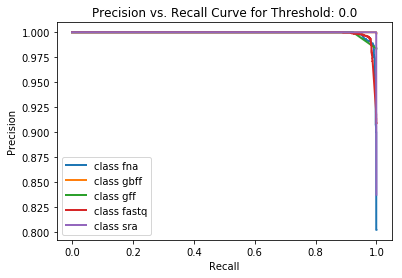

<Figure size 1440x720 with 0 Axes>

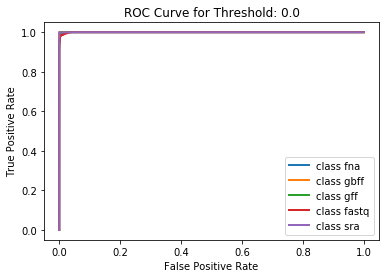

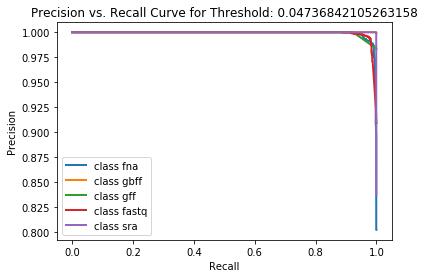

<Figure size 1440x720 with 0 Axes>

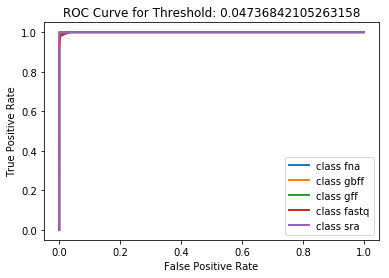

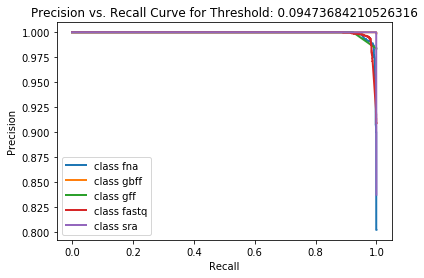

<Figure size 1440x720 with 0 Axes>

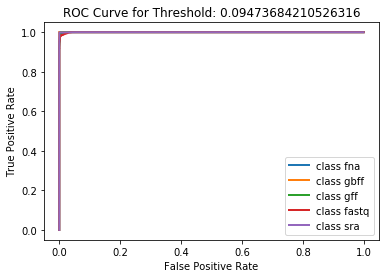

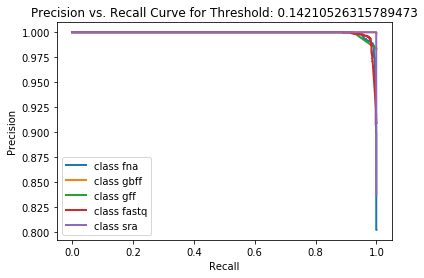

<Figure size 1440x720 with 0 Axes>

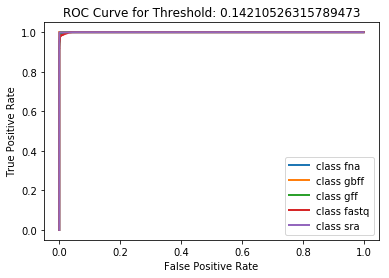

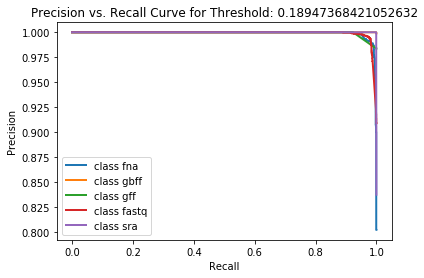

<Figure size 1440x720 with 0 Axes>

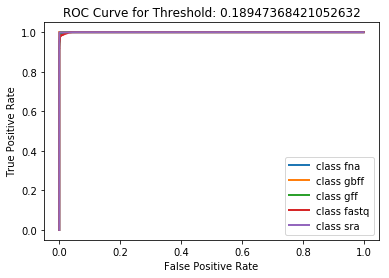

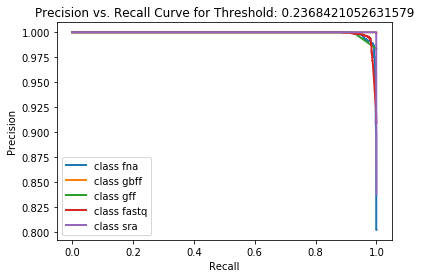

<Figure size 1440x720 with 0 Axes>

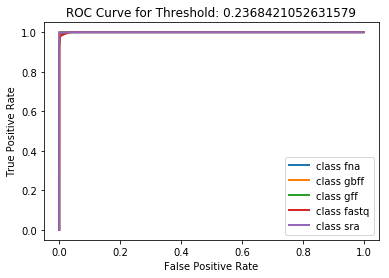

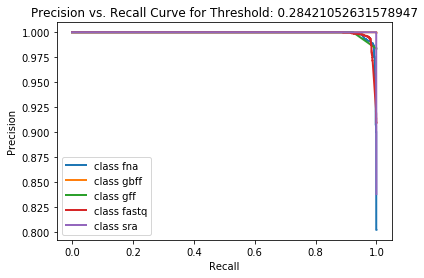

<Figure size 1440x720 with 0 Axes>

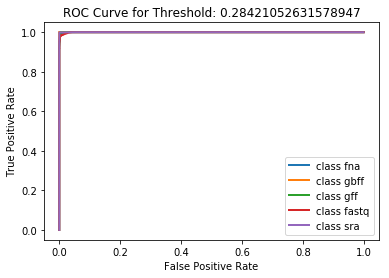

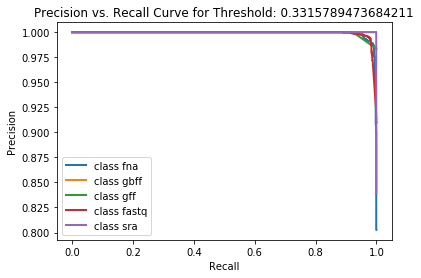

<Figure size 1440x720 with 0 Axes>

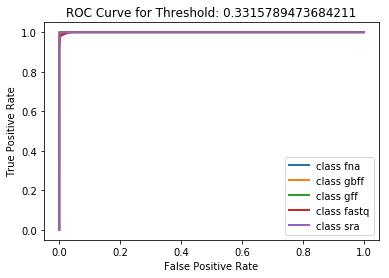

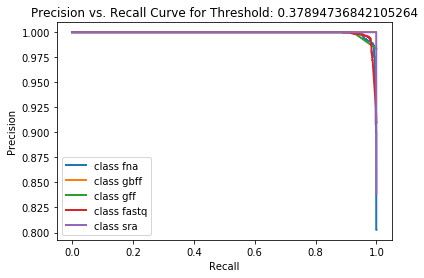

<Figure size 1440x720 with 0 Axes>

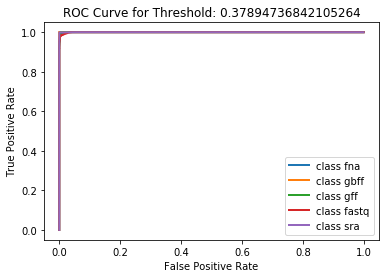

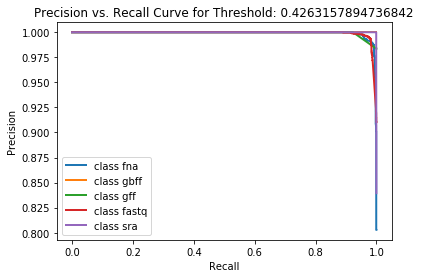

<Figure size 1440x720 with 0 Axes>

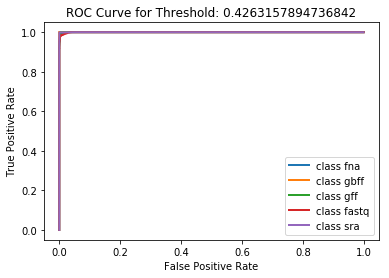

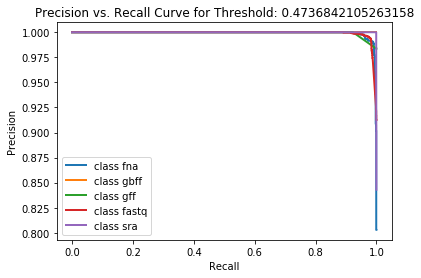

<Figure size 1440x720 with 0 Axes>

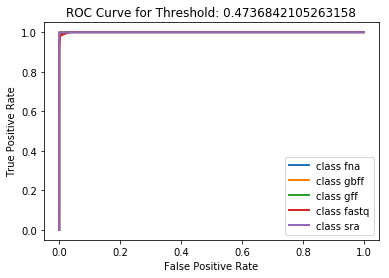

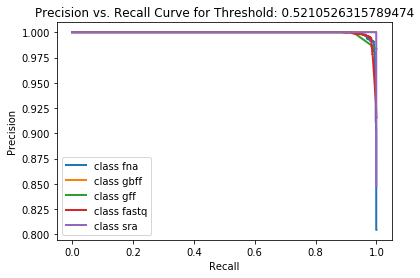

<Figure size 1440x720 with 0 Axes>

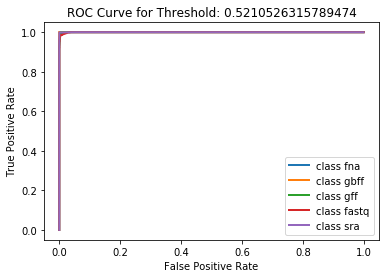

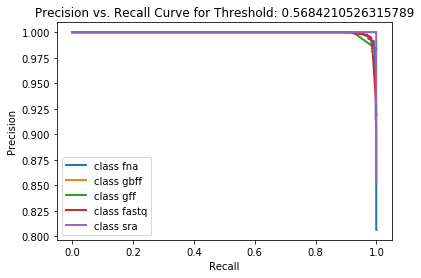

<Figure size 1440x720 with 0 Axes>

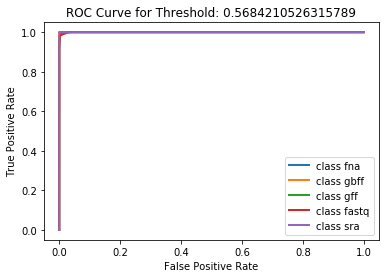

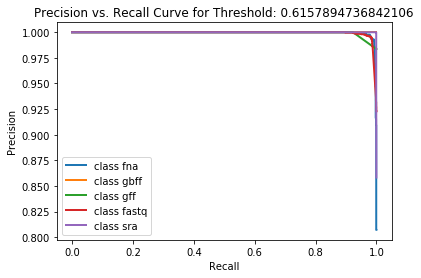

<Figure size 1440x720 with 0 Axes>

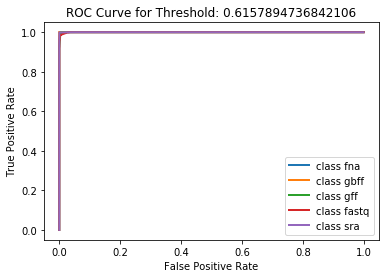

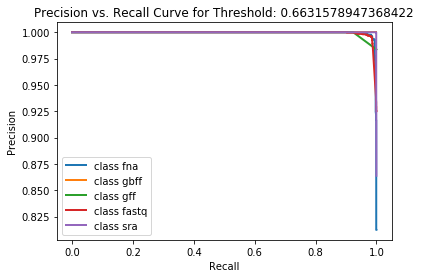

<Figure size 1440x720 with 0 Axes>

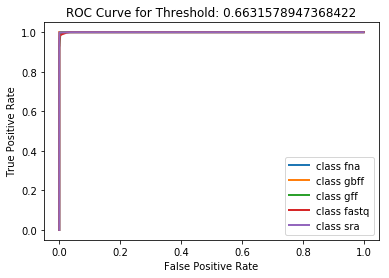

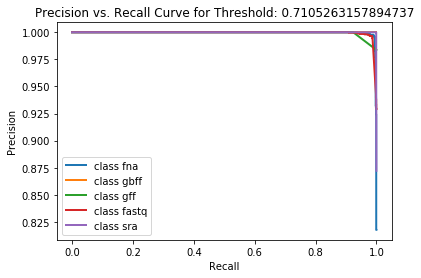

<Figure size 1440x720 with 0 Axes>

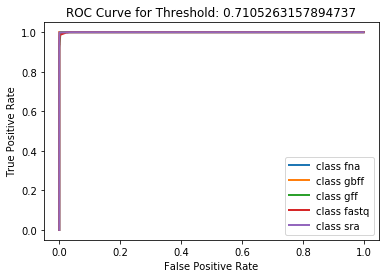

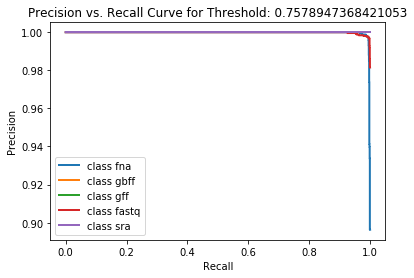

<Figure size 1440x720 with 0 Axes>

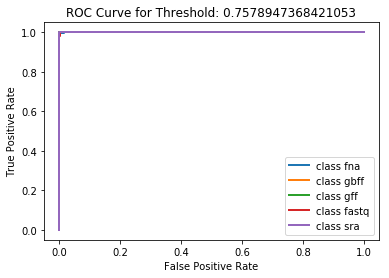

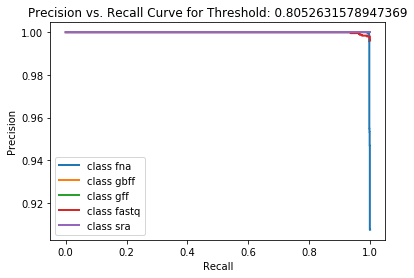

<Figure size 1440x720 with 0 Axes>

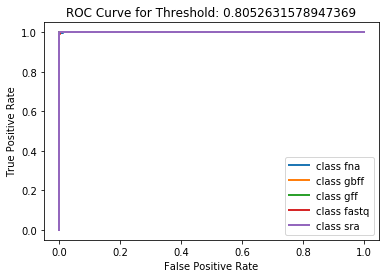

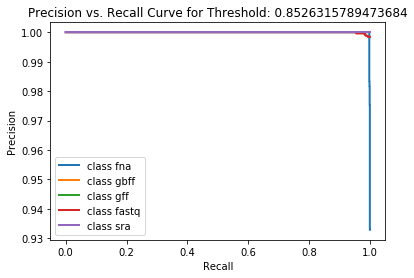

<Figure size 1440x720 with 0 Axes>

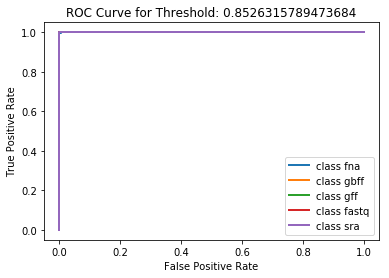

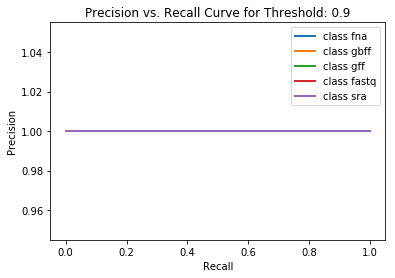

<Figure size 1440x720 with 0 Axes>

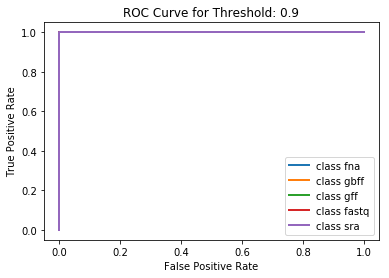

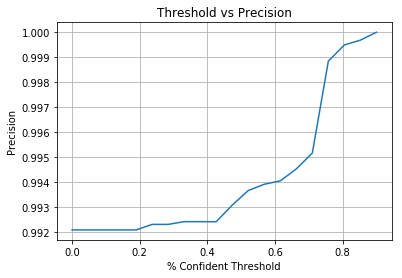

<Figure size 1440x720 with 0 Axes>

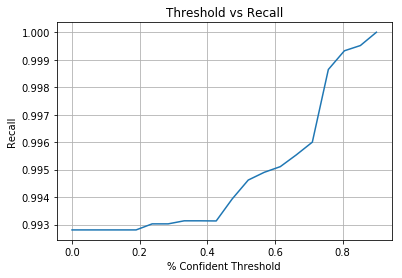

<Figure size 1440x720 with 0 Axes>

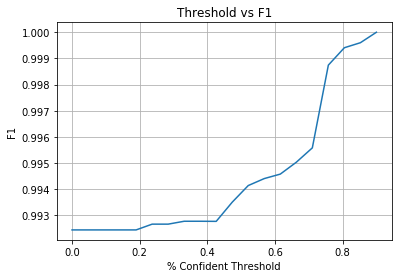

<Figure size 1440x720 with 0 Axes>

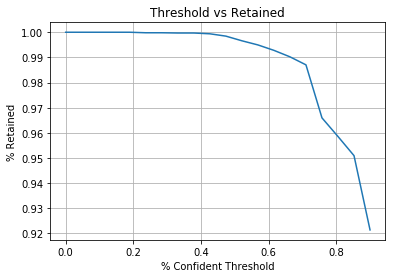

<Figure size 1440x720 with 0 Axes>

array([2, 4, 0, ..., 0, 4, 3])

In [43]:
# XGB Diagnostics on Validation Set

TestFileClassifier(xgbmodel, dat_val, filetype, y_val, output = False, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'xgb')

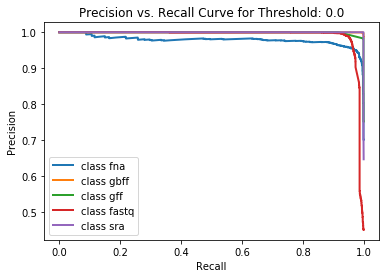

<Figure size 1440x720 with 0 Axes>

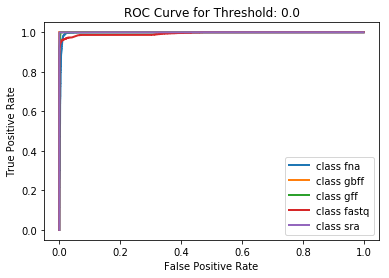

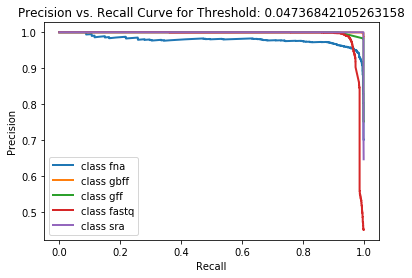

<Figure size 1440x720 with 0 Axes>

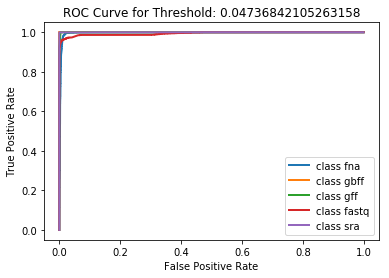

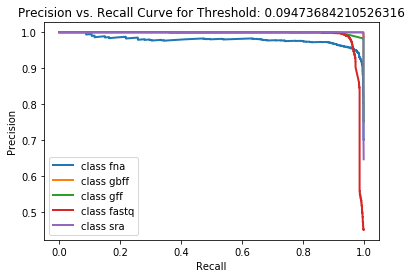

<Figure size 1440x720 with 0 Axes>

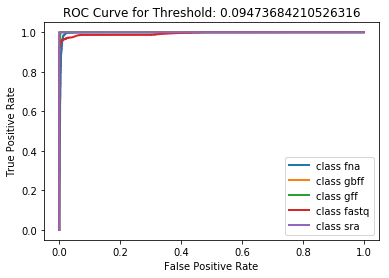

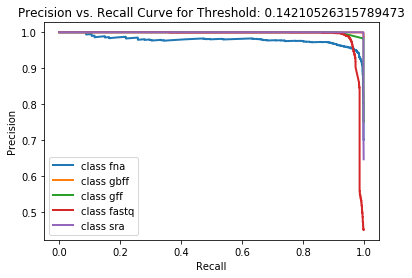

<Figure size 1440x720 with 0 Axes>

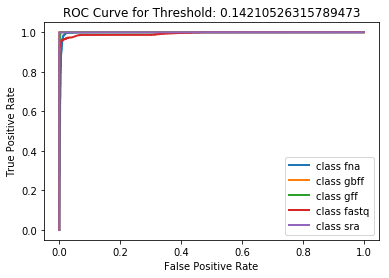

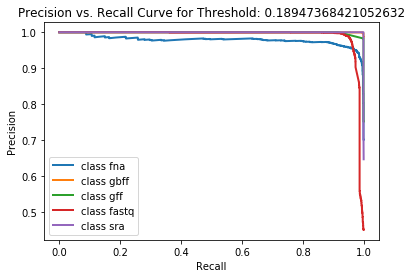

<Figure size 1440x720 with 0 Axes>

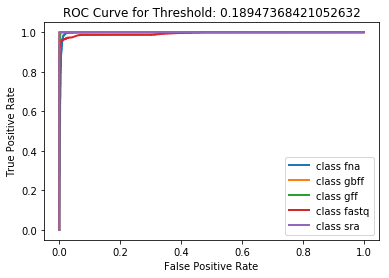

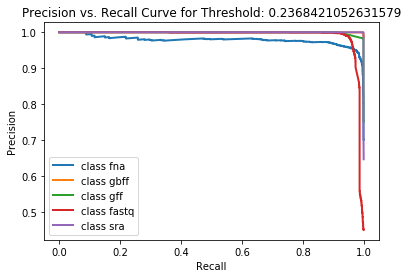

<Figure size 1440x720 with 0 Axes>

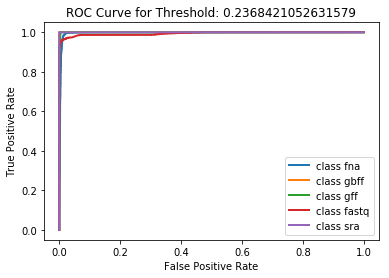

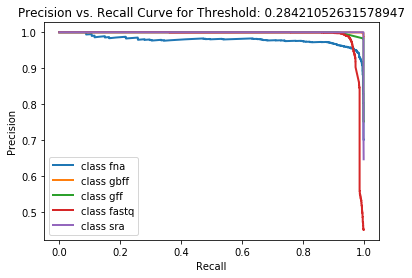

<Figure size 1440x720 with 0 Axes>

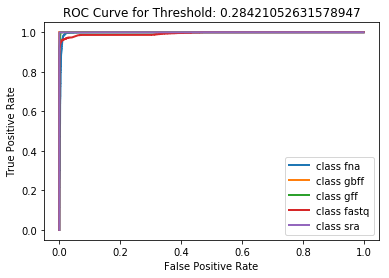

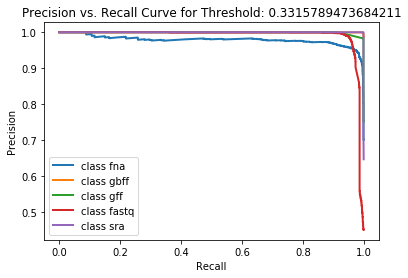

<Figure size 1440x720 with 0 Axes>

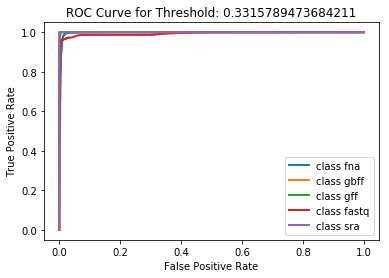

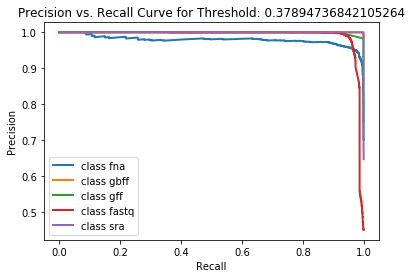

<Figure size 1440x720 with 0 Axes>

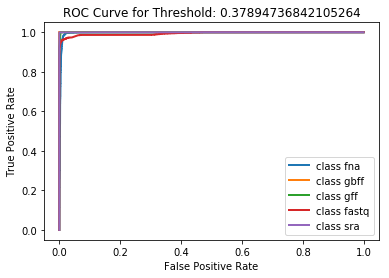

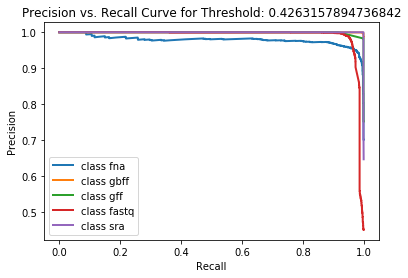

<Figure size 1440x720 with 0 Axes>

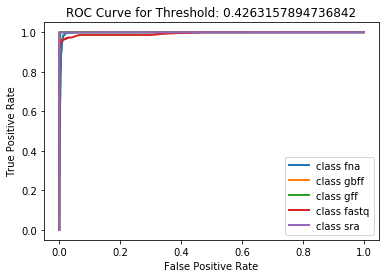

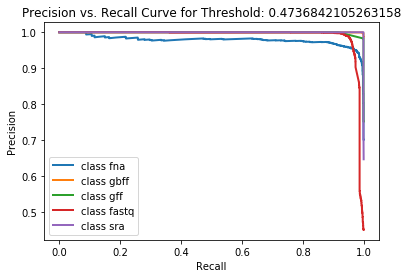

<Figure size 1440x720 with 0 Axes>

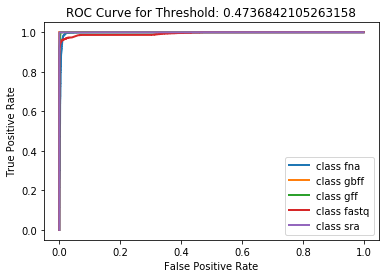

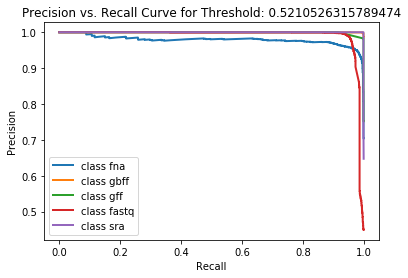

<Figure size 1440x720 with 0 Axes>

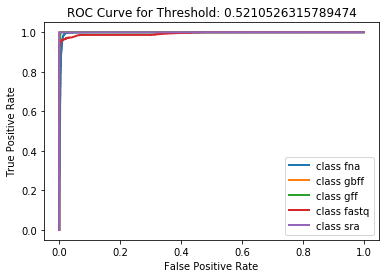

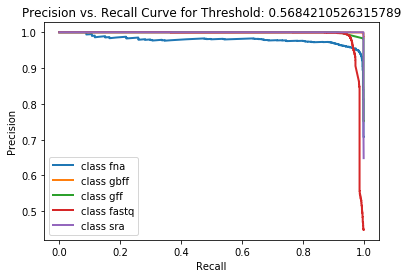

<Figure size 1440x720 with 0 Axes>

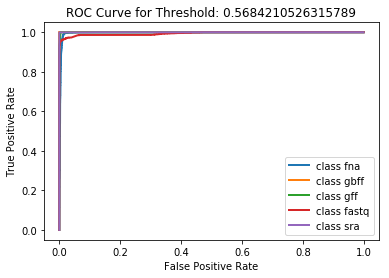

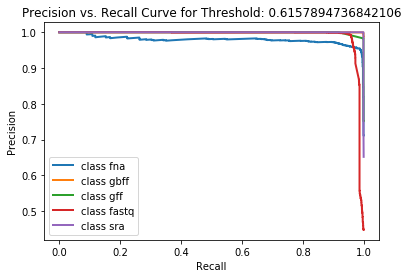

<Figure size 1440x720 with 0 Axes>

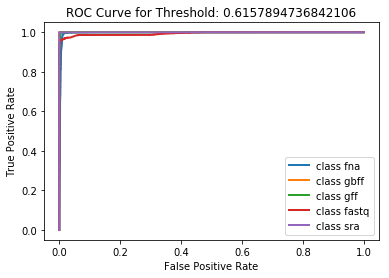

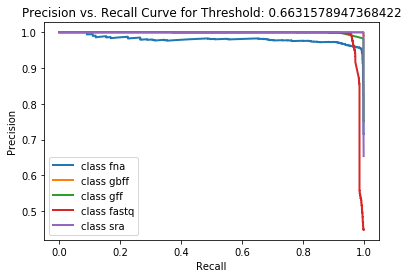

<Figure size 1440x720 with 0 Axes>

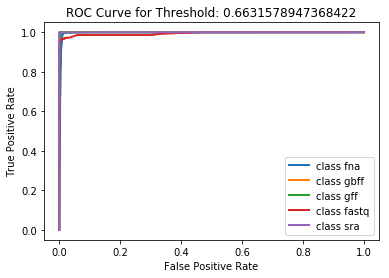

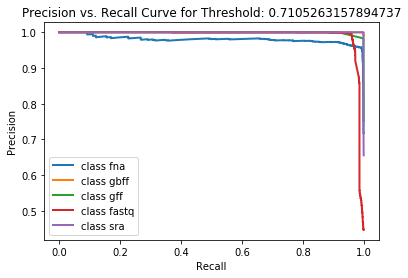

<Figure size 1440x720 with 0 Axes>

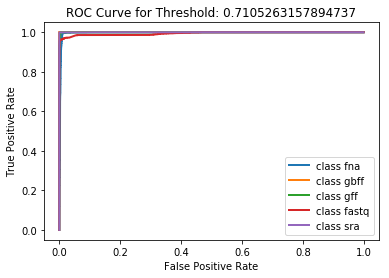

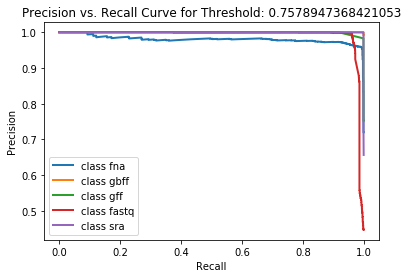

<Figure size 1440x720 with 0 Axes>

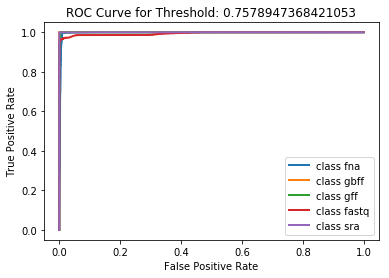

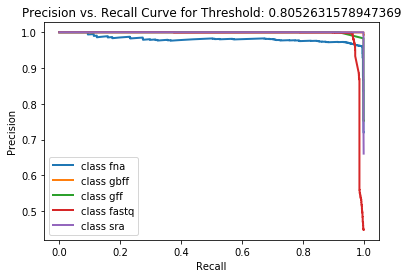

<Figure size 1440x720 with 0 Axes>

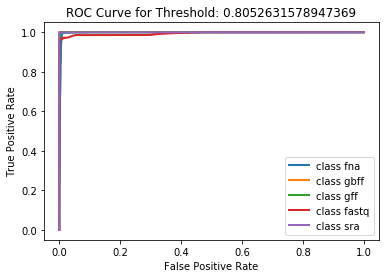

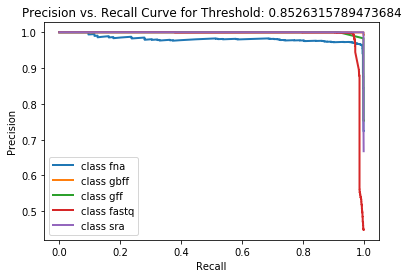

<Figure size 1440x720 with 0 Axes>

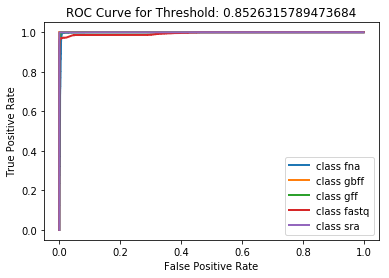

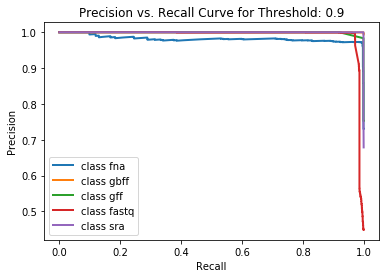

<Figure size 1440x720 with 0 Axes>

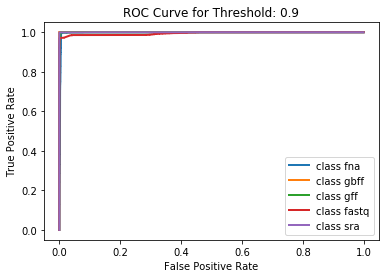

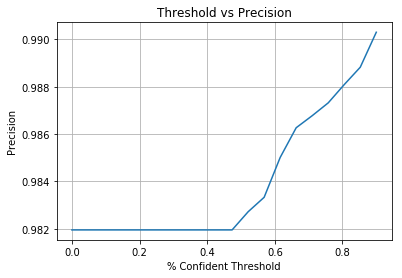

<Figure size 1440x720 with 0 Axes>

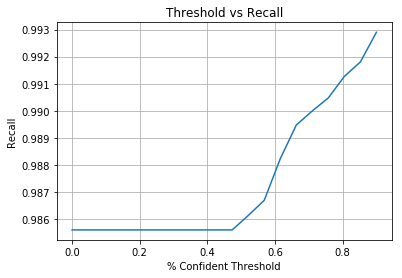

<Figure size 1440x720 with 0 Axes>

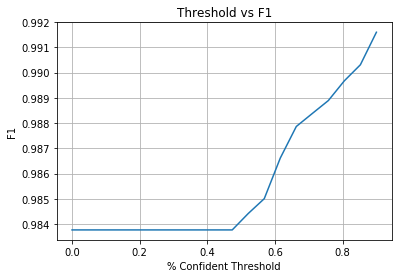

<Figure size 1440x720 with 0 Axes>

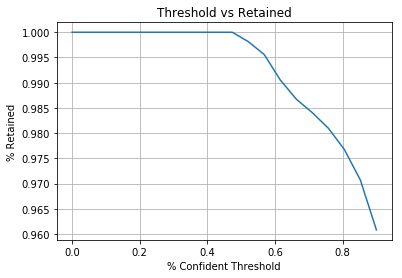

<Figure size 1440x720 with 0 Axes>

array([2, 4, 0, ..., 4, 3, 3])

In [108]:
# SVM Diagnostics on Validation Set

TestFileClassifier(svmmodel, dat_val, filetype, y_val, output = False, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'svm')

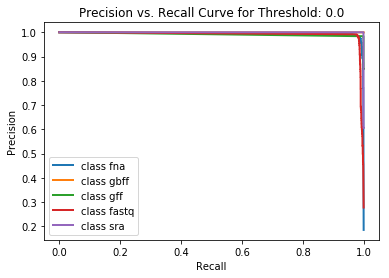

<Figure size 1440x720 with 0 Axes>

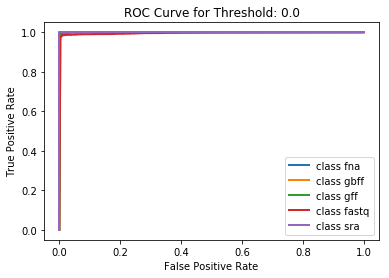

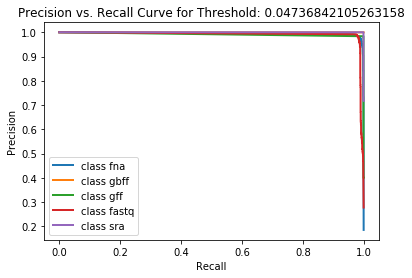

<Figure size 1440x720 with 0 Axes>

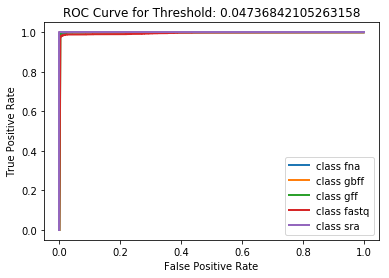

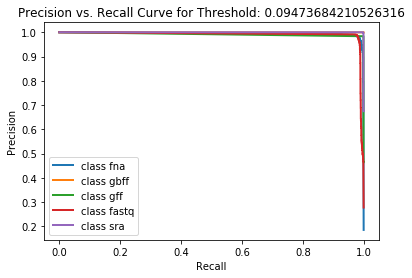

<Figure size 1440x720 with 0 Axes>

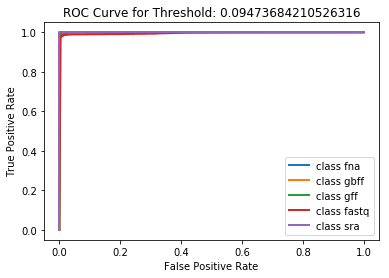

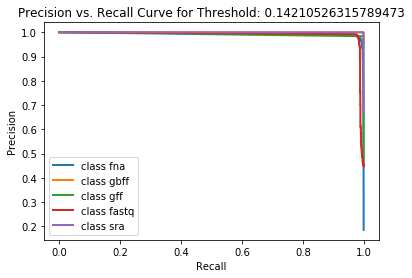

<Figure size 1440x720 with 0 Axes>

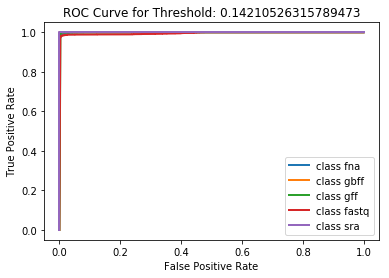

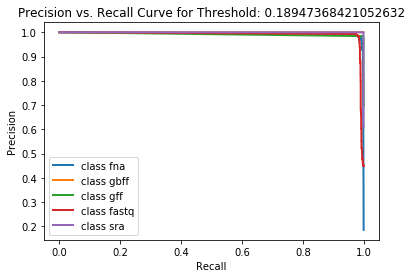

<Figure size 1440x720 with 0 Axes>

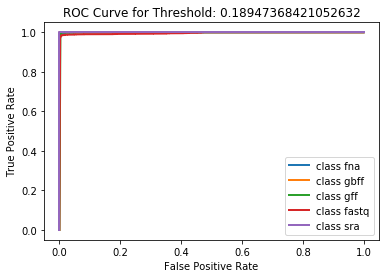

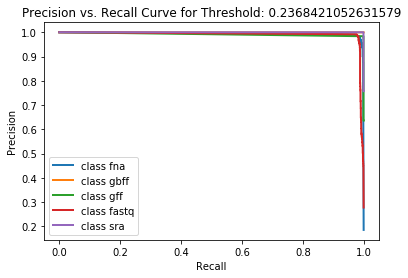

<Figure size 1440x720 with 0 Axes>

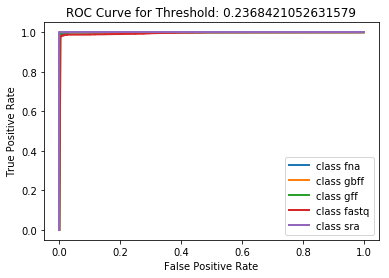

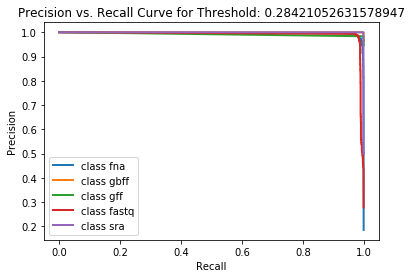

<Figure size 1440x720 with 0 Axes>

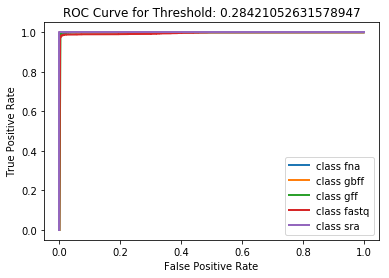

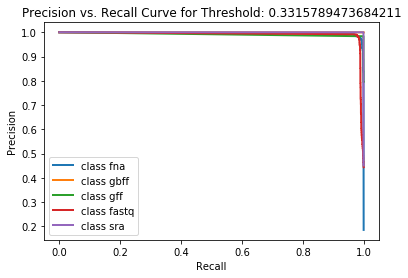

<Figure size 1440x720 with 0 Axes>

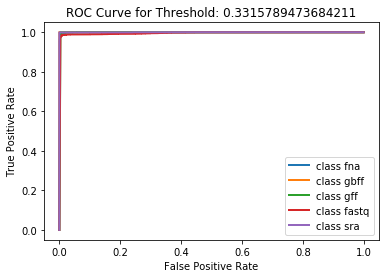

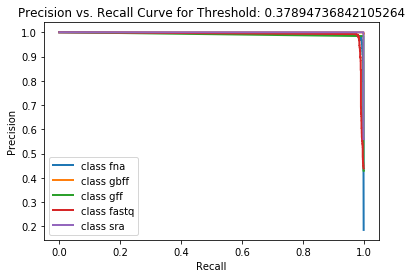

<Figure size 1440x720 with 0 Axes>

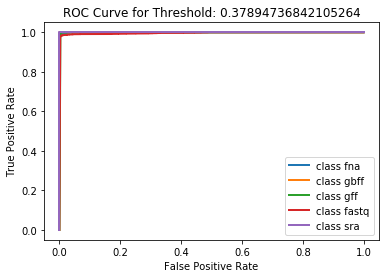

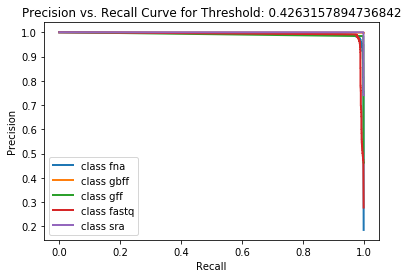

<Figure size 1440x720 with 0 Axes>

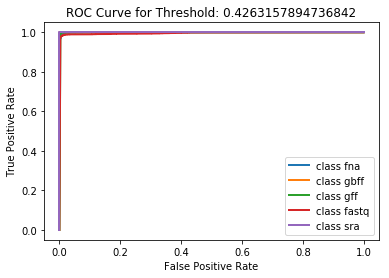

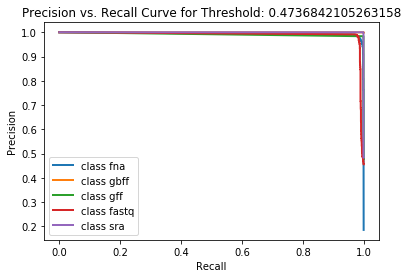

<Figure size 1440x720 with 0 Axes>

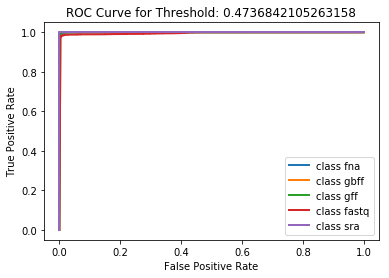

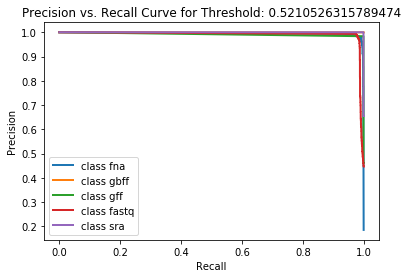

<Figure size 1440x720 with 0 Axes>

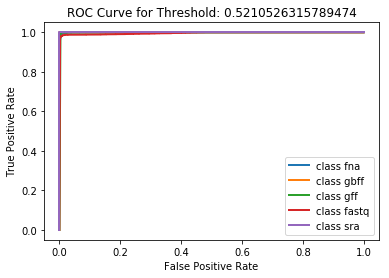

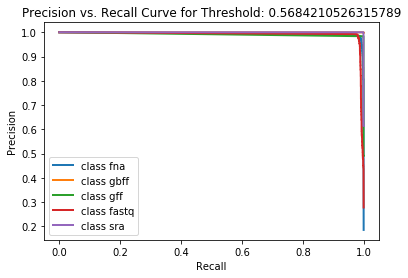

<Figure size 1440x720 with 0 Axes>

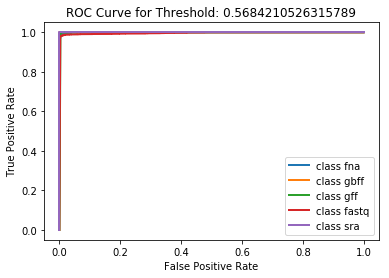

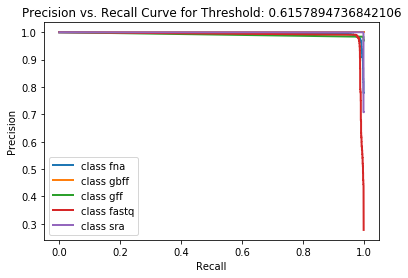

<Figure size 1440x720 with 0 Axes>

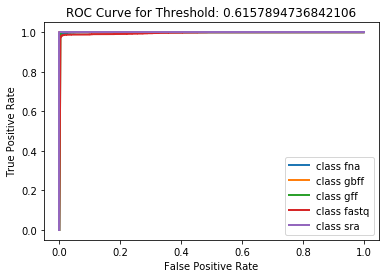

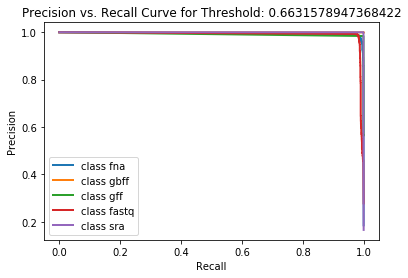

<Figure size 1440x720 with 0 Axes>

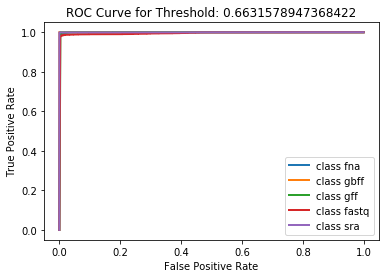

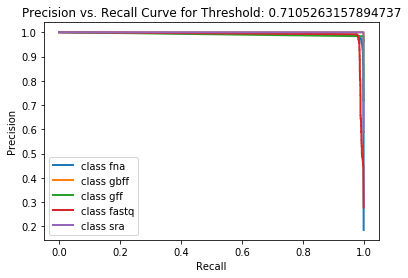

<Figure size 1440x720 with 0 Axes>

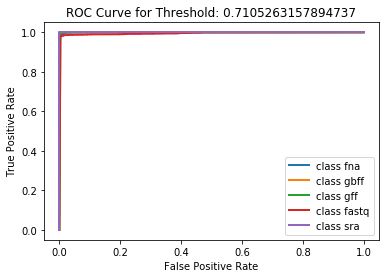

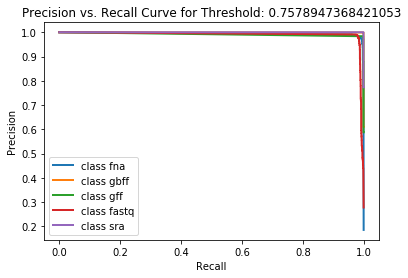

<Figure size 1440x720 with 0 Axes>

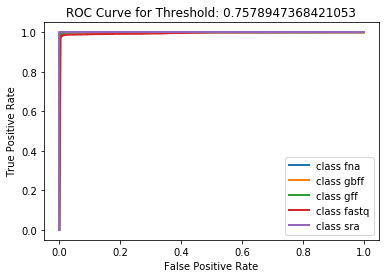

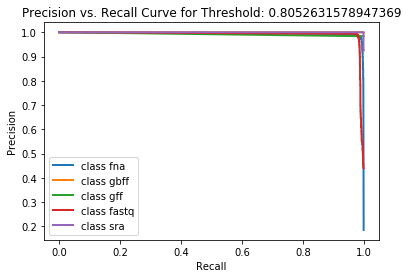

<Figure size 1440x720 with 0 Axes>

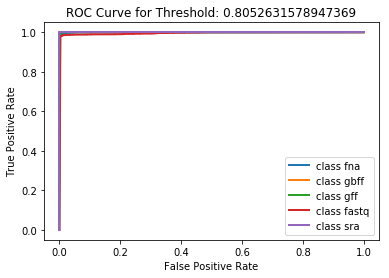

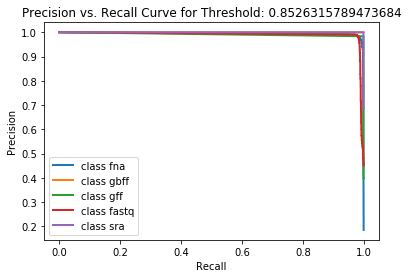

<Figure size 1440x720 with 0 Axes>

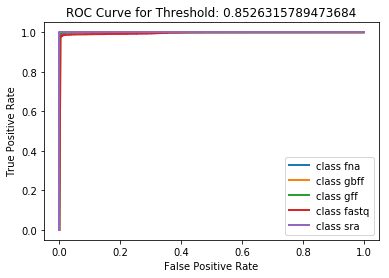

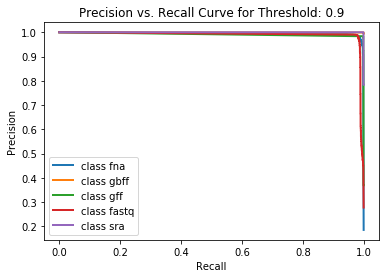

<Figure size 1440x720 with 0 Axes>

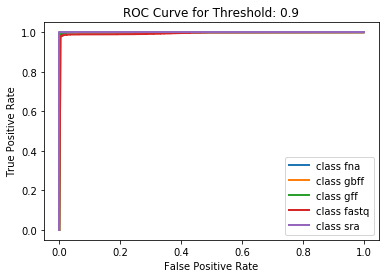

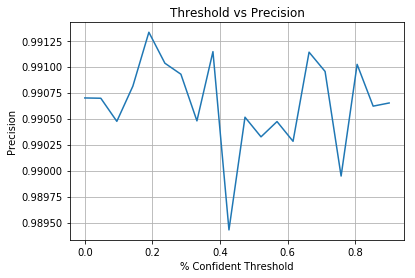

<Figure size 1440x720 with 0 Axes>

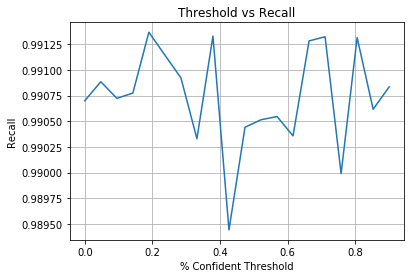

<Figure size 1440x720 with 0 Axes>

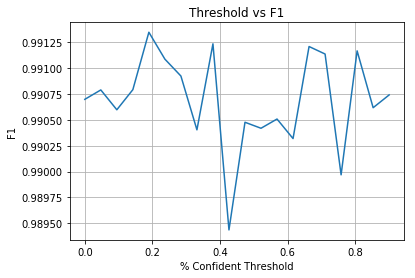

<Figure size 1440x720 with 0 Axes>

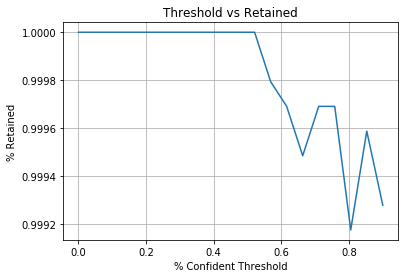

<Figure size 1440x720 with 0 Axes>

array([2, 4, 0, ..., 4, 3, 3])

In [109]:
# MLP Diagnostics on Validation Set

TestFileClassifier(mlpmodel, dat_val, filetype, y_val, output = False, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'mlp')

In [40]:
# Test Set is transformed via TF-IDF Vectorizer

dat_test = test_char_vectorizer(X_test)

Loading Character Vectorizer...
Character Vectorizer Loaded
['aaaa', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', ' gen', 'geno', 'enom', 'nome', ' :: ', 'atio', 'tion ', 'genom', 'enome', 'ation', '=gen', 'prot', 'rote', 'otei', 'tein', 'prote', 'rotei', 'otein', 'protei', 'rotein', 'protein', 'gene', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', 'gggggggg', 'ffffffff', 'iiii', '\x01\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Vectorizer Load Time: 64


In [77]:
FileVecTime(X_test, test_char_vectorizer, 1000, 1, xgbmodel)

(0.00870511531829834, 0.0019447091400731946)

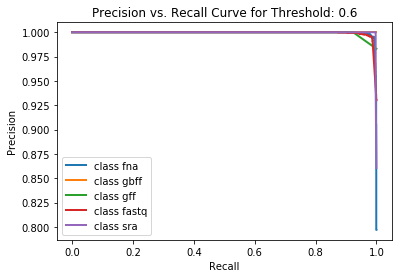

<Figure size 1440x720 with 0 Axes>

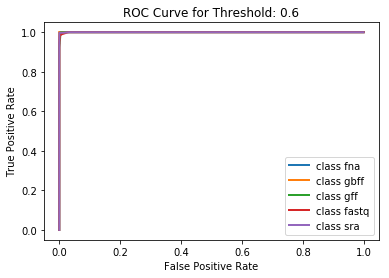

Testing time: 0
Precision: 0.994467933711702
Recall: 0.9952467120154923
F1: 0.9948571704559019
Class fna mean and sd: [0.8850229, 0.06103204], Accuracy: 0.99
Class gbff mean and sd: [0.8983565, 0.018815476], Accuracy: 1.0
Class gff mean and sd: [0.88387996, 0.046805006], Accuracy: 1.0
Class fastq mean and sd: [0.8857234, 0.05352614], Accuracy: 0.99
Class sra mean and sd: [0.89963764, 0.00016815087], Accuracy: 1.0


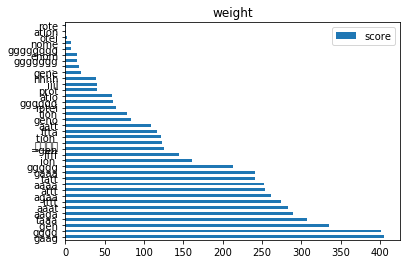

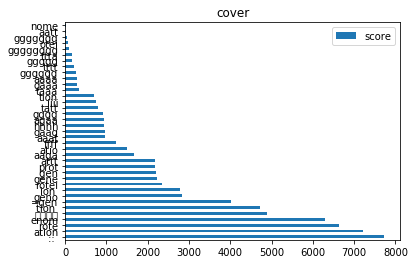

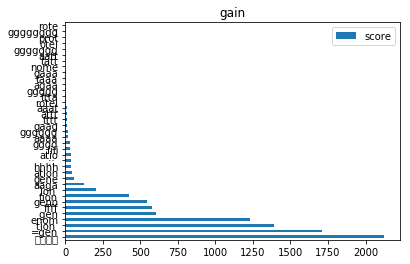

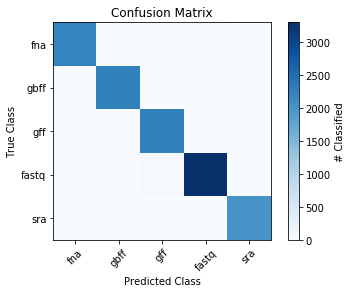

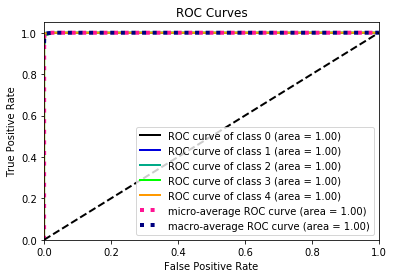

array([3, 3, 1, ..., 1, 2, 3])

In [107]:
# Test Set XGB Classifier

TestFileClassifier(xgbmodel, dat_test, filetype, y_test, output = True, threshold = [0.6], threshold_plots = False, classifier = 'xgb')

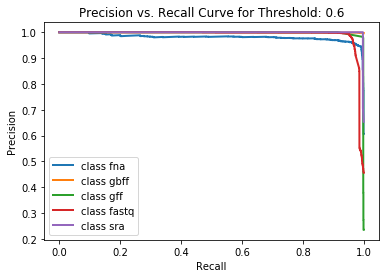

<Figure size 1440x720 with 0 Axes>

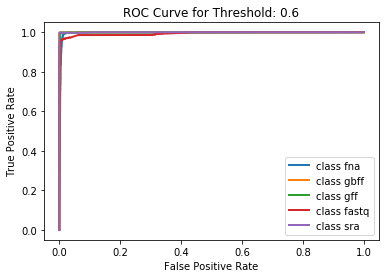

Testing time: 3
Precision: 0.9837841207824422
Recall: 0.9871917894936793
F1: 0.9854850093369515
Class fna mean and sd: [0.954931926016789, 0.0878173187036315], Accuracy: 0.99
Class gbff mean and sd: [0.9973797014990293, 0.023086876513261585], Accuracy: 1.0
Class gff mean and sd: [0.9938466297987238, 0.019219823311333158], Accuracy: 1.0
Class fastq mean and sd: [0.9800379230578743, 0.07402789677904538], Accuracy: 0.95
Class sra mean and sd: [0.9578957385843144, 0.0004425803670415482], Accuracy: 1.0


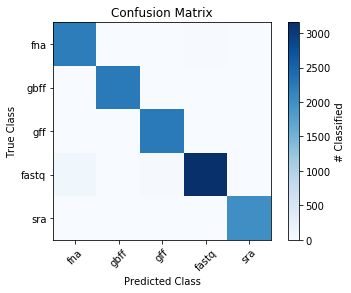

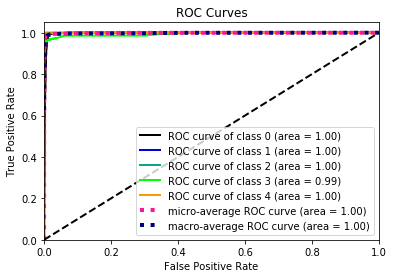

array([3, 3, 1, ..., 1, 2, 3])

In [81]:
# Test Set SVM Classifier

TestFileClassifier(svmmodel, dat_test, filetype, y_test, output = True, threshold = [0.6], threshold_plots = False, classifier = 'svm')

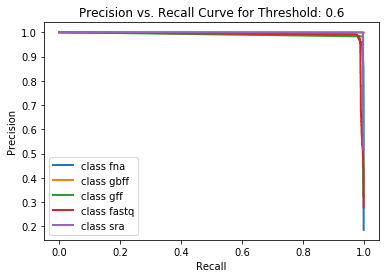

<Figure size 1440x720 with 0 Axes>

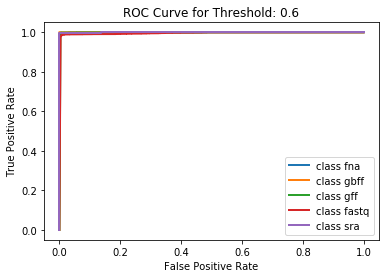

Testing time: 0
Precision: 0.9908538802621368
Recall: 0.9907726496931787
F1: 0.9908132633127614
Class fna mean and sd: [0.9996423, 0.0080352165], Accuracy: 0.98
Class gbff mean and sd: [0.9999773, 0.0010772998], Accuracy: 1.0
Class gff mean and sd: [0.99999535, 0.00019262558], Accuracy: 1.0
Class fastq mean and sd: [0.9999091, 0.0023332557], Accuracy: 0.98
Class sra mean and sd: [0.99999434, 0.0002536941], Accuracy: 1.0


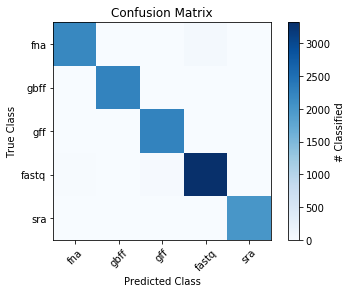

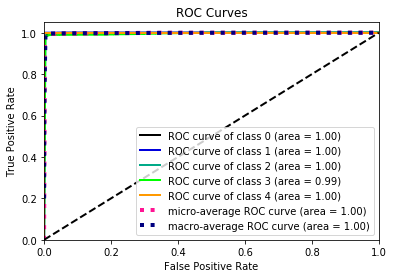

array([3, 3, 1, ..., 1, 2, 3])

In [82]:
# Test Set MLP Classifier

TestFileClassifier(mlpmodel, dat_test, filetype, y_test, output = True, threshold = [0.6], threshold_plots = False, classifier = 'mlp')